In [68]:
import numpy as np
import pandas as pd
import sklearn
import ot
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds


In [3]:
ratings_train = np.load('../datasets/ratings_train.npy')
ratings_test = np.load('../datasets/ratings_test.npy')
m,n = ratings_train.shape
data = np.nan_to_num(ratings_train)

movies_average_rating = np.nanmean(ratings_train, axis=0)
users_average_rating = np.nanmean(ratings_train, axis=1)
movies_average_rating_normalized = movies_average_rating / movies_average_rating.sum()
users_average_rating_normalized = users_average_rating / users_average_rating.sum()

movies_total_rating = np.nansum(ratings_train, axis=0)
users_total_rating = np.nansum(ratings_train, axis=1)
users_normalized_total_rating = users_total_rating / users_total_rating.sum()
movies_normalized_total_rating = movies_total_rating / movies_total_rating.sum()


In [100]:
def regularization(c,l, type='l2'):
    if type == 'l2':
        return l*np.power(np.linalg.norm(c),2)/2
    elif type == 'l1':
        return l*np.linalg.norm(c, ord='1')

def gradient_ridge_reg(c,c_hat,gamma,l, type='l2'):
    if type == 'l2':
        return l*c + (c - c_hat)/gamma
    if type == 'l1':
        return (c - c_hat)/gamma

def compute_prox(c_hat, h_prox, x0, iterations = 10, gamma = 0.01, epsilon = 0.001,l = 0.1): #h is the non-differentiable function
    xk = x0
    gk = np.power(np.linalg.norm(xk-c_hat),2)/(2*gamma)
    for i in range(iterations):
        xk_old = xk
        # compute gradient for differentiable  part of function
        gk_gradient = gradient_ridge_reg(xk,c_hat,gamma,l, type='l2')
        # take gradient step to reduce g(x)
        xk_gradient = xk - gamma * gk_gradient
        # proximal update to reduce h(x) but stay close to xk_gradient
        xk = xk_gradient #Change if h is constraining function

        # print(np.linalg.norm(xk - xk_old))
        if np.linalg.norm(xk - xk_old) < epsilon:
            print(f'prox gradoent converges in {i} iters')
            return xk

    return xk

def current_h(x,gamma):
    return 0

def function_to_optimize(c_hat, x, gamma):
    m = c_hat.shape[0]
    n = c_hat.shape[1]
    x = x.reshape((m,n))
    return np.linalg.norm(x-c_hat)/(2*gamma)

def cost_learning(data, pi_hat,mu,nu,epsilon,G, D, steps = 100):
    m,n = pi_hat.shape
    alpha = np.random.rand(m,1)
    beta = np.random.rand(n,1)
    u = np.exp(alpha / epsilon)
    v = np.exp(beta / epsilon)
    c = data
    
    G_inv = np.linalg.pinv(G)
    D_inv = np.linalg.pinv(D)

    A = np.random.rand(G_inv.shape[1], D_inv.shape[1])
    
    c_s = []
    
    for i in range(steps):
        print(i)
        K = np.exp(-c/epsilon)
        kv = np.dot(K,v).reshape(m,1)
        u = np.divide(mu.reshape(1,m),kv.reshape(1,m)).reshape(m,1)
        ktu = np.dot(K.T,u).reshape(n,1)
        v = np.divide(nu.reshape(1,n),ktu.reshape(1,n)).reshape(n,1)
        K = pi_hat / (np.dot(u,v.T))
        log_k = np.log(K, out=np.zeros_like(K), where=(K!=0))
        A_deomposed = G_inv.T@log_k@D_inv
        A = compute_prox(-epsilon*A_deomposed,current_h,A)
        # res = minimize(lambda x: function_to_optimize(c_hat=-epsilon*A_deomposed, x=x, gamma=.01), A.flatten(), bounds=Bounds(lb=1e-6))
        # A = res.x.reshape(A_deomposed.shape)
        c = G.T@A@D
        # c = np.log(1 + np.exp(c))
        #c_s.append(c)
        #c = compute_prox(-epsilon*log_k,current_h,c)
        # if np.linalg.norm(c - c_s[-1]) < epsilon:
            # print(f'Cs equivalent in iteration {i}')


    return epsilon*np.log(u),epsilon*np.log(v),c


def transform_to_integers(matrix):
    num_intervals = 10
    min_value = matrix.min()
    max_value = matrix.max()

    # Calculate the interval width
    interval_width = (max_value - min_value) / num_intervals

    # Map the values to integers between 1 and 10
    transformed_matrix = ((matrix - min_value) / interval_width).clip(0, num_intervals).astype(int) / 2

    return transformed_matrix


def compute_rmse(predictions, test_matrix):
  masked = np.ma.array(test_matrix, mask=np.isnan(test_matrix))
  masked_preds = np.ma.array(predictions, mask=np.isnan(predictions))
  diff = np.ma.subtract(masked_preds, masked)
  squared = np.ma.power(diff, 2)
  return np.ma.sqrt(np.ma.mean(squared))


In [105]:
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

user_dist = pdist(data, metric='jaccard')
user_sim_matrix = squareform(user_dist)
W = pca.fit_transform(user_sim_matrix)

movie_dist = pdist(data.T, metric='jaccard')
movie_sim_matrix = squareform(movie_dist)
H = pca.fit_transform(movie_sim_matrix)


In [5]:
from sklearn.decomposition import NMF
import scipy.sparse as sps

csr_ratings_train = sps.csr_matrix(np.nan_to_num(ratings_train), shape=(610, 4980))
csr_ratings_train.eliminate_zeros()

nmf = NMF(n_components=10, init='nndsvd', random_state=0, max_iter=200)
W = nmf.fit_transform(csr_ratings_train)
H = nmf.components_


/Users/ellington/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [101]:
np.nan_to_num(ratings_train)[0,2]
W[0,2]
H[0,2]
(W@H)[0,2]


0.21682584729918158

In [95]:
data = np.nan_to_num(ratings_train)
pi_hat = data / data.sum()

mu_hat = pi_hat.sum(axis = 1)
nu_hat = pi_hat.sum(axis = 0)

G = W.T
D = H
# G = user_sim_matrix
# D = movie_sim_matrix

lambd = 1e-3
Gs = ot.sinkhorn(mu_hat, nu_hat, data, lambd)

epsilon = .01

alpha,beta,c = cost_learning(data, pi_hat, mu_hat, nu_hat, epsilon, G, D, steps=10)


0
prox gradoent converges in 2 iters
1
prox gradoent converges in 1 iters
2
prox gradoent converges in 1 iters
3
prox gradoent converges in 1 iters
4
prox gradoent converges in 1 iters
5
prox gradoent converges in 1 iters
6
prox gradoent converges in 1 iters
7
prox gradoent converges in 1 iters
8
prox gradoent converges in 1 iters
9
prox gradoent converges in 1 iters


In [102]:
# otm = ot.emd(data.sum(axis=1), data.sum(axis=0), c, numItermax=1000000)
otm_scores = transform_to_integers(c)
print(compute_rmse(otm_scores, ratings_train))
print(compute_rmse(otm_scores, ratings_test))


1.168859966968312
1.179335278115917


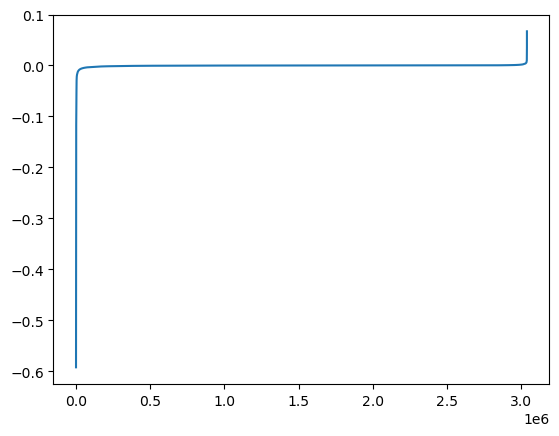

In [104]:
flattened = c.flatten()
flattened.sort()
plt.plot(range(len(flattened)), flattened)


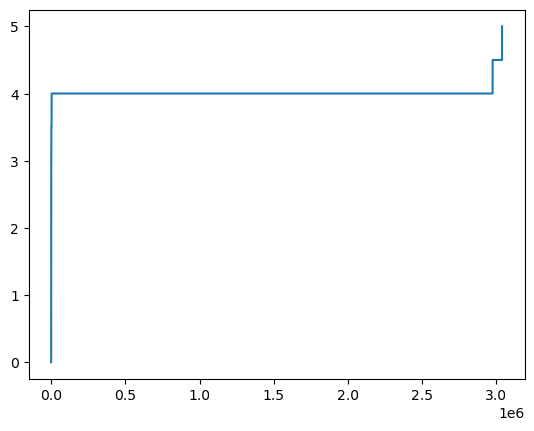

In [103]:
flattened = otm_scores.flatten()
flattened.sort()
plt.plot(range(len(flattened)), flattened)


In [86]:
print(np.linalg.norm(c))


0.46311835504720006


In [32]:
np.unique(otm_scores, return_counts=True)


(610, 4980)